In [1]:
import torch
from fastai.vision.all import *
import os

if torch.cuda.is_available():
    print("CUDA is available on this system.")
else:
    print("CUDA is NOT available on this system.")

/home/ippen/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is available on this system.


In [2]:
torch.cuda.empty_cache()

In [3]:
# Fix Display behavior in Jupyter Notebooks for VS Code
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [4]:
import re

def get_state_label(file_path):
    filename = os.path.basename(file_path)
    state_pattern = r"__class_(\w+)-"
    state_match = re.search(state_pattern, filename)
    if state_match:
        return state_match.group(1)
    else:
        raise ValueError(f"State-Class pattern not found in filename: {filename}")

def get_pictogram_label(file_path):
    filename = os.path.basename(file_path)
    pictogram_pattern = r"-(\w+).png$"
    pictogram_match = re.search(pictogram_pattern, filename)
    if pictogram_match:
        return pictogram_match.group(1)
    else:
        raise ValueError(f"Pictogram-Class pattern not found in filename: {filename}")

In [10]:
import albumentations

class AlbumentationsTransform(DisplayedTransform):
    split_idx,order=0,2
    def __init__(self, train_aug): store_attr()
    
    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

def get_train_aug(): return albumentations.Compose([
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.4, 
                val_shift_limit=0.2, 
                p=1.0
            )
])

In [11]:
dataset_path = "/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_rect_combined/"
train_folder = 'train'
valid_folder = 'valid'

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock, CategoryBlock),
                   n_inp=1,
                   get_items=get_image_files,
                   get_y=[get_state_label, get_pictogram_label],
                   item_tfms=[Resize(224, ResizeMethod.Pad, pad_mode='zeros'), AlbumentationsTransform(get_train_aug())],
                   batch_tfms=[*aug_transforms(size=224, do_flip=False, max_rotate=3, max_warp=0.1), Contrast(max_lighting=0.25)])

dls = dblock.dataloaders(dataset_path, path=dataset_path, train=train_folder, valid=valid_folder, bs=64)

In [12]:
print("Train size: " + str(len(dls.train.items))+ " | Valid size: " + str(len(dls.valid.items)))

Train size: 17280 | Valid size: 4319


In [13]:
dls.vocab

(#2) [['green', 'off', 'red', 'red_yellow', 'yellow'],['arrow_left', 'arrow_right', 'arrow_straight', 'circle']]

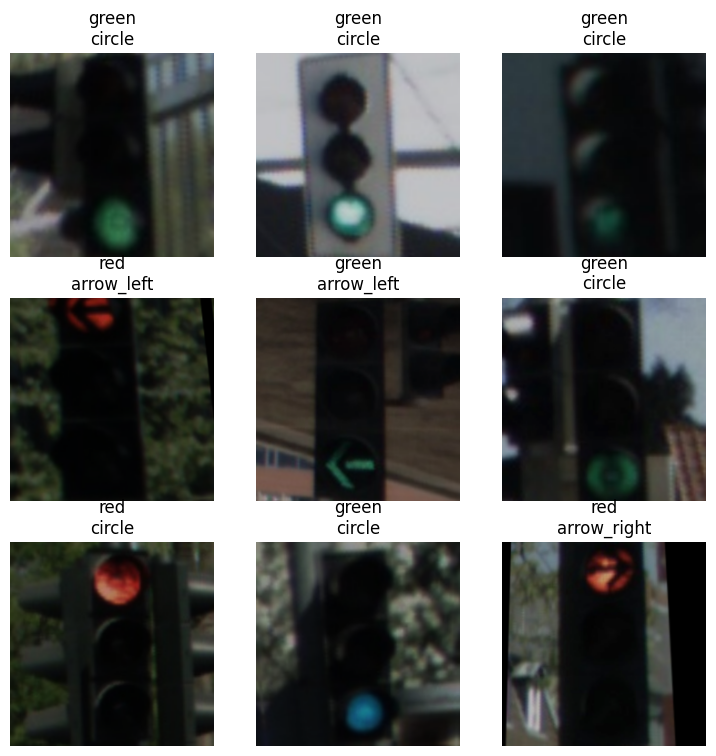

In [14]:
dls.show_batch(max_n=9)

In [40]:
state_percentage = [0.5548,0.0749,0.3009,0.022,0.0405] # green, off, red, red_yellow, yellow
reciprocal_state_percentage = 1/np.array(state_percentage)
norm_rec_state_percentage = reciprocal_state_percentage/reciprocal_state_percentage.sum()   # weights for state loss function

pictogram_percentage = [0.135, 0.0204, 0.0794, 0.7646] # arrow_left, arrow_right, arrow_straight, off
reciprocal_pictogram_percentage = 1/np.array(pictogram_percentage)
norm_rec_pictogram_percentage = reciprocal_pictogram_percentage/reciprocal_pictogram_percentage.sum()   # weights for pictogram loss function


In [41]:
def state_loss(inp,state,pictogram): return F.cross_entropy(inp[:,:5],state, weight=torch.tensor(norm_rec_state_percentage, device = 'cuda:0', dtype=torch.float32))
    
def pictogram_loss(inp,state,pictogram): return F.cross_entropy(inp[:,5:],pictogram, weight=torch.tensor(norm_rec_pictogram_percentage, device = 'cuda:0', dtype=torch.float32))

In [42]:
def combine_loss(inp, state, pictogram):return state_loss(inp, state, pictogram) + pictogram_loss(inp, state, pictogram)

In [43]:
def state_err(inp,state,pictogram): return error_rate(inp[:,:5],state)
def pictogram_err(inp,state,pictogram): return error_rate(inp[:,5:],pictogram)

err_metrics = (state_err, pictogram_err)

In [44]:
all_metrics = err_metrics + (state_loss, pictogram_loss)

In [45]:
# Define your own custom model class
class DualSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, xb):
        x1, x2 = torch.split(xb, [5, 4], dim=1) # Split tensor into two parts with sizes [5, 4] along dimension 1
        x1 = F.softmax(x1, dim=1)  # Apply softmax to the first part along dimension 1
        x2 = F.softmax(x2, dim=1)  # Apply softmax to the second part along dimension 1
        x = torch.cat((x1, x2), dim=1)  # Concatenate the two parts back together along dimension 1
        return x

In [46]:
learn = vision_learner(dls, convnext_tiny, loss_func=combine_loss, metrics=all_metrics, n_out=9)

/home/ippen/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ippen/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
learn.model[-1] = nn.Sequential(*learn.model[-1], DualSoftmax())

In [48]:
learn.unfreeze()

SuggestedLRs(valley=0.0008317637839354575)

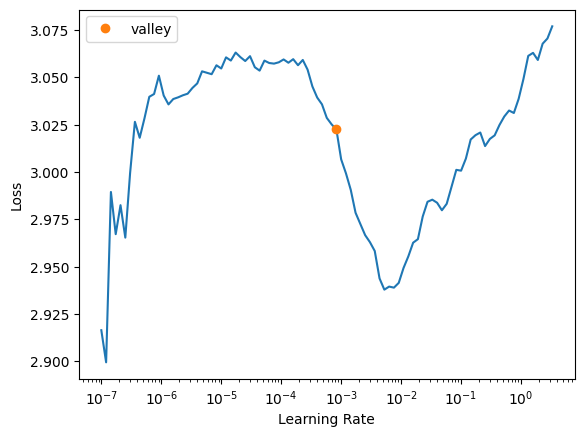

In [49]:
learn.lr_find()

In [50]:
learn.fit(3, lr=0.9e-4)

epoch,train_loss,valid_loss,state_err,pictogram_err,state_loss,pictogram_loss,time
0,1.933957,1.781122,0.049780,0.147488,0.961232,0.819889,02:13
1,1.759794,1.749163,0.023154,0.092382,0.944016,0.805147,02:13
2,1.762320,1.731266,0.021996,0.088446,0.941566,0.789700,02:13


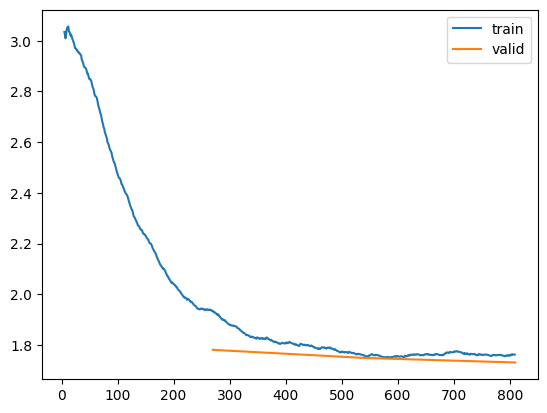

In [51]:
learn.recorder.plot_loss()

In [52]:
learn.save('tl_v2.4')

Path('/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_rect_combined/models/tl_v2.4.pth')

In [53]:
def predict(img_path):
    tst_dl = learn.dls.test_dl([img_path])
    pred = learn.get_preds(dl=tst_dl)
    return pred[0][0]

def get_class(pred):
    states = ["green", "off", "red", "red_yellow", "yellow"]
    pictogram = ["arrow_left", "arrow_right", "arrow_straight", "circle"]
    pred_states = pred[:5]
    pred_pictogram = pred[5:]
    return states[pred_states.argmax()] + " " + pictogram[pred_pictogram.argmax()]

def get_probability(pred):
    pred_states = pred[:5]
    pred_pictogram = pred[5:]
    return max(pred_states), max(pred_pictogram)


tensor([7.9716e-01, 1.2031e-01, 6.1958e-03, 6.9367e-02, 6.9642e-03, 1.1295e-03,
        6.0299e-03, 6.1088e-04, 9.9223e-01])

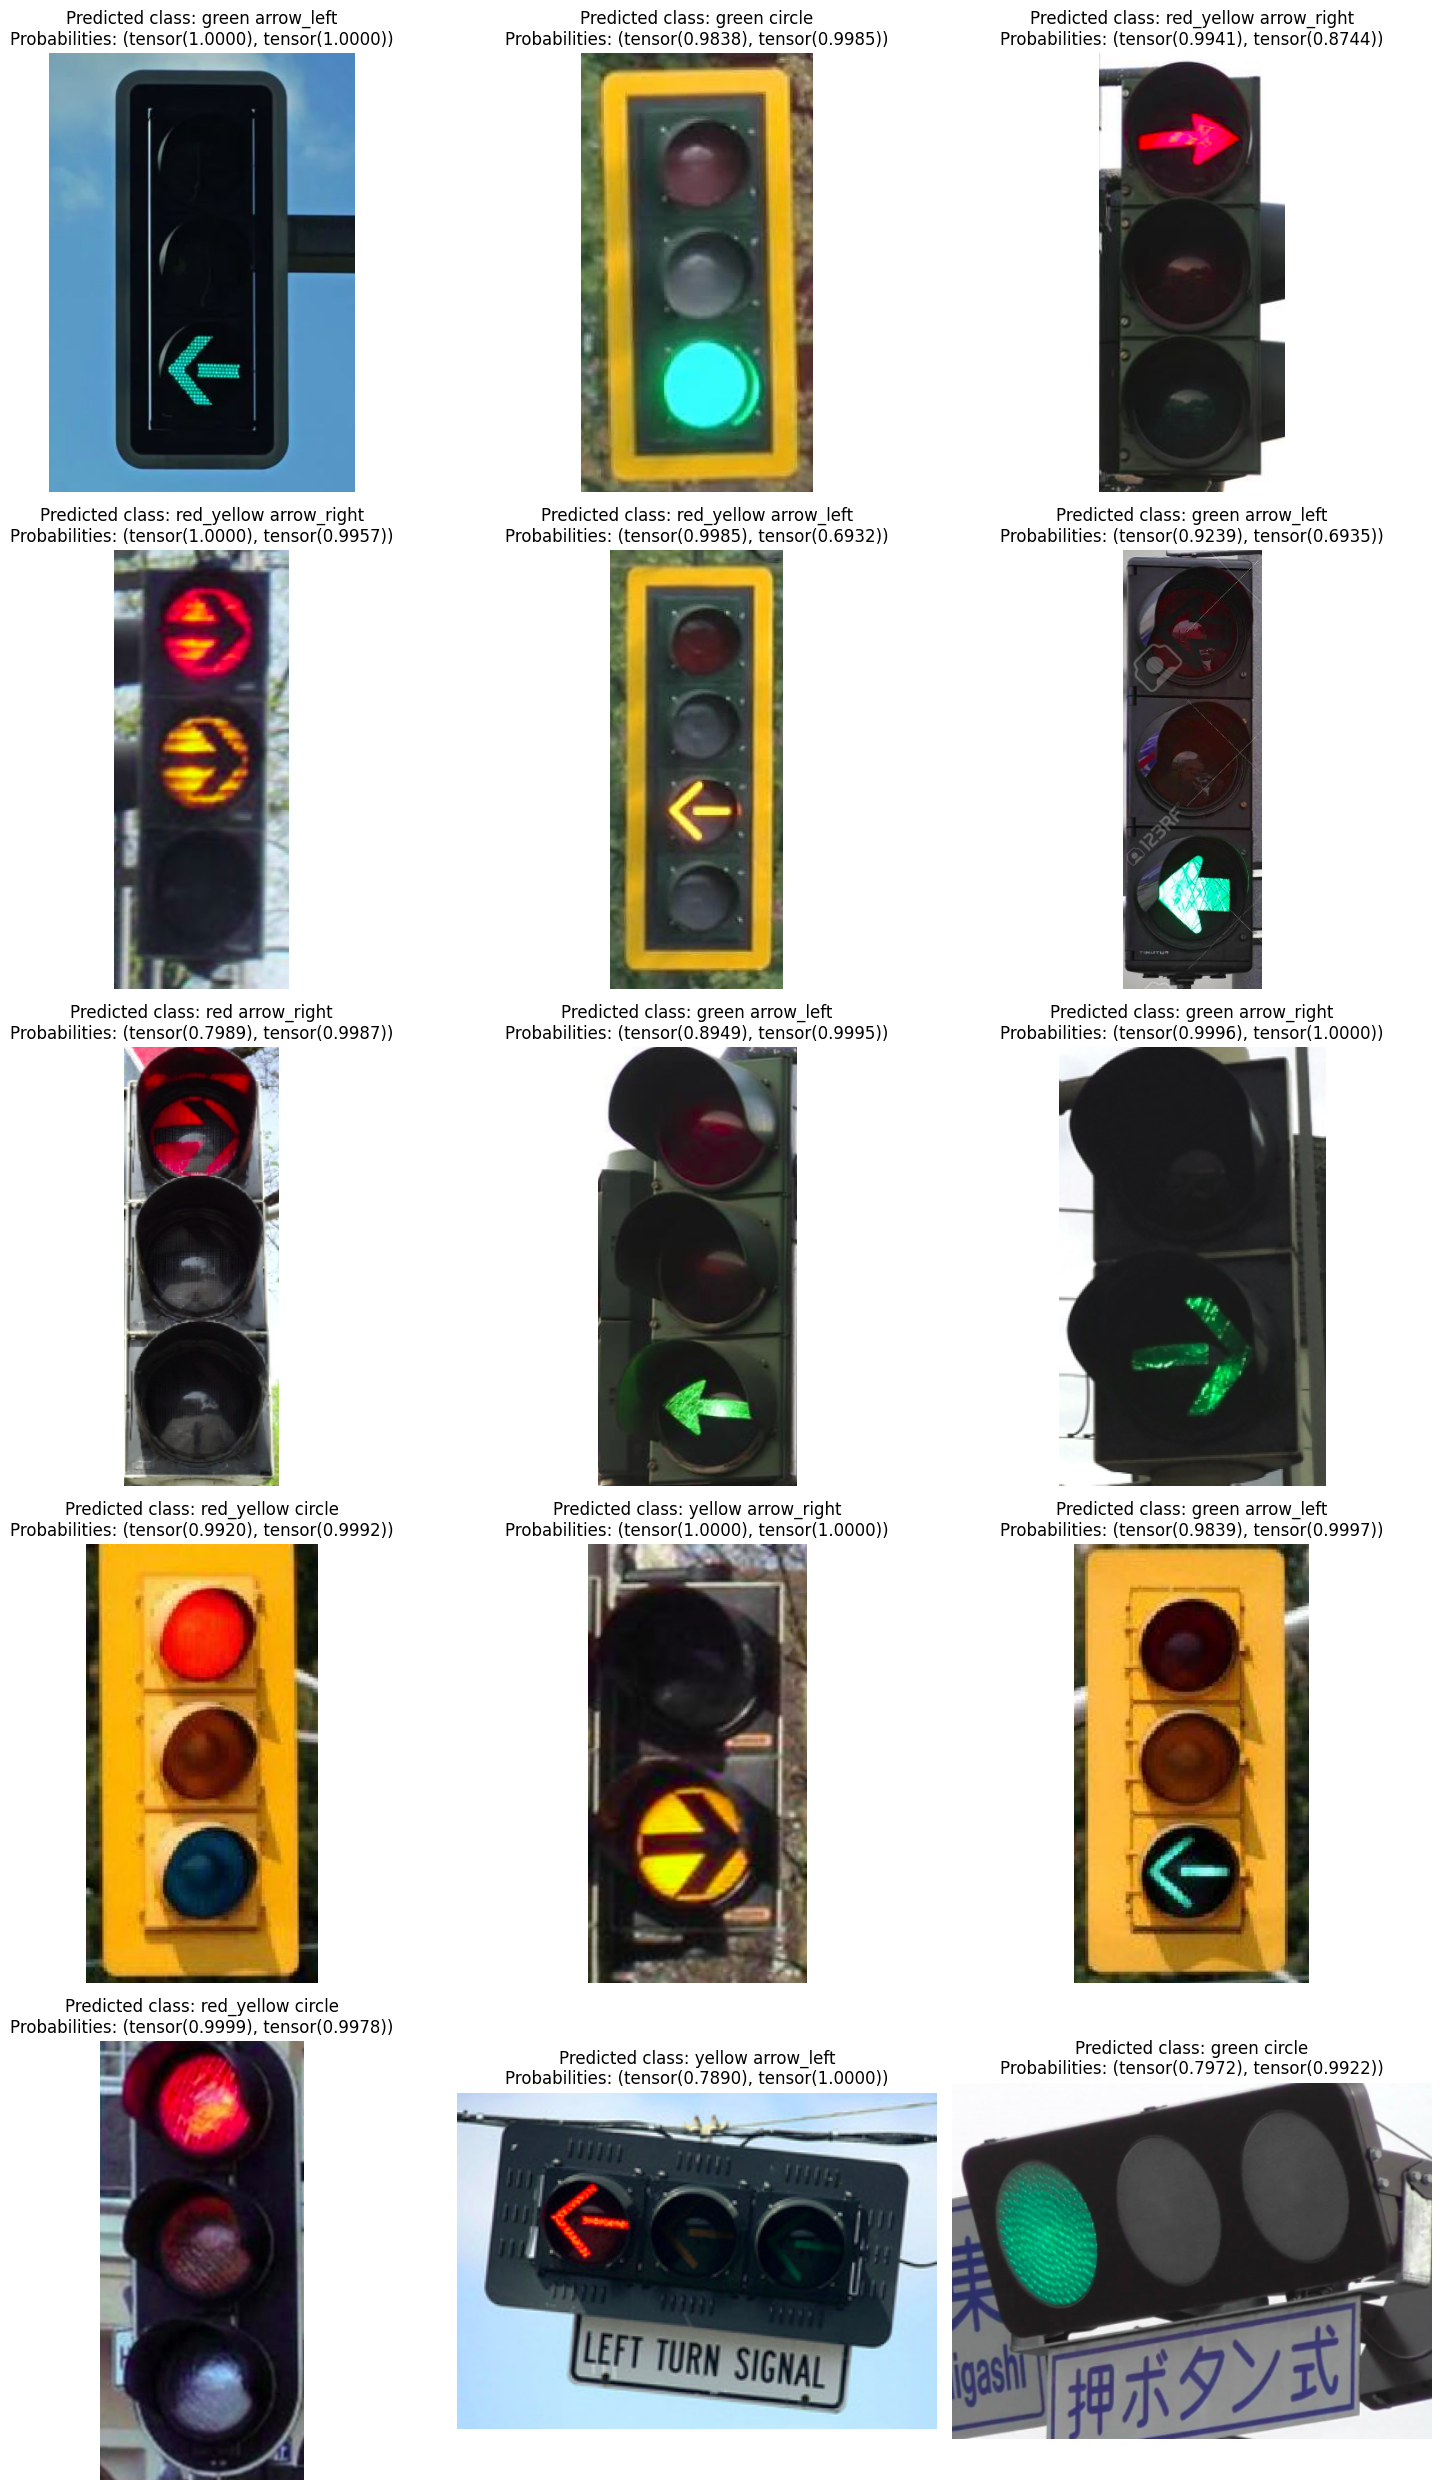

In [54]:
import matplotlib.pyplot as plt

folder_path = "/home/ippen/personal/traffic-light-classification/datasets/samples"

# Get a list of all image files in the folder
image_files = get_image_files(folder_path)

# Define the cropping transformation
crop_transform = Resize(224, ResizeMethod.Pad, pad_mode='zeros')

# Calculate the number of rows and columns for the subplot grid
num_images = len(image_files)
num_cols = 3  # Number of columns in the grid
num_rows = (num_images - 1) // num_cols + 1  # Number of rows in the grid

# Create the subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Iterate over the image files and make predictions
for idx, image_file in enumerate(image_files):
    img = PILImage.create(image_file)
    
    # Use the learner to predict the cropped image
    prediction = predict(image_file)
    display(prediction)

    # Access the predicted class and associated probabilities
    predicted_class = get_class(prediction)
    probabilities = get_probability(prediction)

    # Plot the image and display the predicted class and probabilities
    ax = axs[idx // num_cols, idx % num_cols]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Predicted class: {predicted_class}\nProbabilities: {probabilities}")

# Adjust the spacing between subplots and display the plot
plt.tight_layout()
plt.show()

In [55]:
import matplotlib.pyplot as plt

folder_path = "/home/ippen/personal/traffic-light-classification/datasets/samples"

# Get a list of all image files in the folder
image_files = get_image_files(folder_path)

# Define the cropping transformation
crop_transform = Resize(224, ResizeMethod.Pad, pad_mode='zeros')


img = PILImage.create(folder_path + "/" + "img1.png")

# Use the learner to predict the cropped image
prediction = predict(image_file)
display(prediction)

# Access the predicted class and associated probabilities
predicted_class = get_class(prediction)
probabilities = get_probability(prediction)
display(predicted_class)
display(probabilities)
display(sum(prediction[:5]))


tensor([7.9716e-01, 1.2031e-01, 6.1958e-03, 6.9367e-02, 6.9642e-03, 1.1295e-03,
        6.0299e-03, 6.1088e-04, 9.9223e-01])

'green circle'

(tensor(0.7972), tensor(0.9922))

tensor(1.0000)

In [56]:
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 96 x 56 x 56   
Conv2d                                    4704       True      
LayerNorm2d                               192        True      
Conv2d                                    4800       True      
____________________________________________________________________________
                     64 x 56 x 56 x 96   
Permute                                                        
LayerNorm                                 192        True      
____________________________________________________________________________
                     64 x 56 x 56 x 384  
Linear                                    37248      True      
GELU                                                           
____________________________________________________________________________
                     64 x 56 x 56 x 96   
Linear                                    36

### Results
- Finally a much better result by unfreezing and training the whole model with a good learning rate. Pictogram and state seem much more consistent :)